In [ ]:
!pip install mne


In [ ]:
!pip install autoreject

# Final Code

Creating RawArray with float64 data, n_channels=8, n_times=60871
    Range : 0 ... 60870 =      0.000 ...   243.480 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)



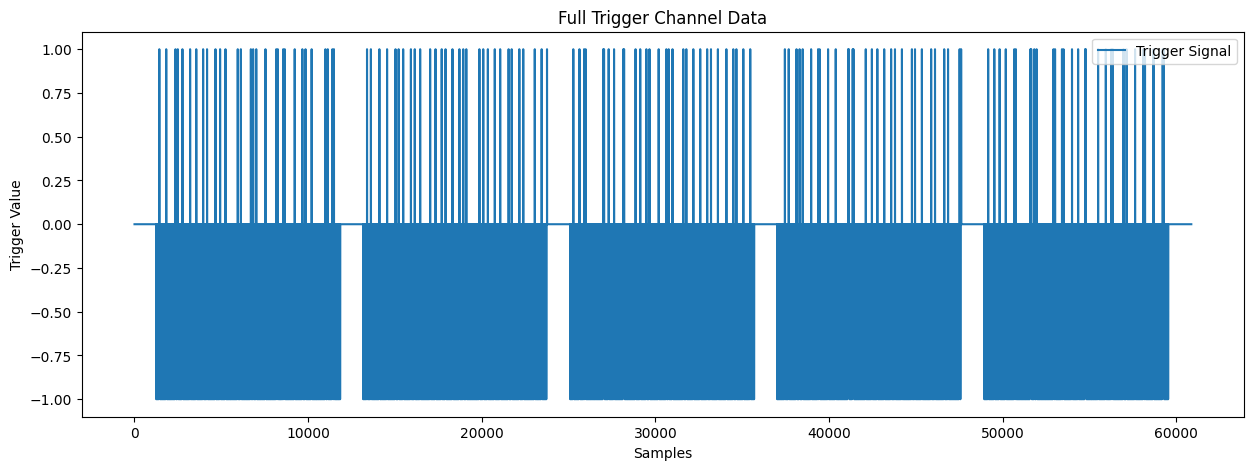

<ipython-input-17-6f434700818d>:77: RuntimeWarning: event 0 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp, event_id=event_id)


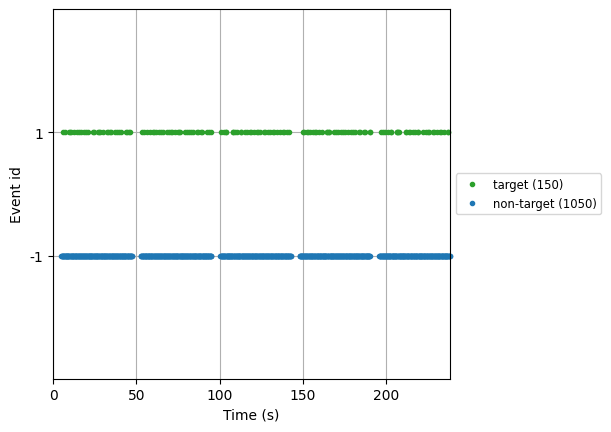

Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 226 original time points ...
0 bad epochs dropped
Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 276 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Re

In [ ]:
import numpy as np
import scipy.io as sio
import mne
import matplotlib.pyplot as plt
from mne import pick_types

# Define functions for loading data, preprocessing, and artifact rejection
def load_data(file_path):
    mat_data = sio.loadmat(file_path)
    fs = mat_data['fs'][0, 0]  # Sampling frequency
    y = mat_data['y']  # EEG data
    trig = mat_data['trig'][:, 0]  # Ensure trig is 1D
    return y, trig, fs

def preprocess_eeg_data(y, trig, fs):
    ch_names = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'Oz', 'PO8']
    ch_types = ['eeg'] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types=ch_types)
    info.set_montage('standard_1020')
    # create raw structure
    raw = mne.io.RawArray(y.T, info)
    # set the average reference
    raw.set_eeg_reference('average', projection=False)
    raw.filter(1., 30., fir_design='firwin')
    return raw, trig

def reject_artifacts(raw, trig, threshold=3.0):
    data = raw.get_data()
    stds = np.std(data, axis=0)
    mean_std = np.mean(stds)
    valid_indices = stds < mean_std * threshold

    cleaned_data = data[:, valid_indices]
    cleaned_trig = trig[valid_indices]
    cleaned_raw = mne.io.RawArray(cleaned_data, raw.info)
    return cleaned_raw, cleaned_trig

def reject_parameter(raw, events):
    picks = pick_types(raw.info, meg=True, eeg=True, stim=False)
    # Define event IDs
    event_id = {'non-target': -1, 'target': 1}
    dummy_epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.1, tmax=1.0,
                     picks=picks, baseline=(None, 0), preload=True,
                     reject=None)

    from autoreject import get_rejection_threshold  # noqa
    reject = get_rejection_threshold(dummy_epochs)
    return reject

def plot_full_trigger_data(trig):
    plt.figure(figsize=(15, 5))
    plt.plot(trig, label='Trigger Signal')
    plt.title('Full Trigger Channel Data')
    plt.xlabel('Samples')
    plt.ylabel('Trigger Value')
    plt.legend()
    plt.show()

# Load and preprocess the data
file_path = '/content/S1.mat'  #'/Users/diptyajit.das/Documents/p300/S4.mat'

y, trig, fs = load_data(file_path)
raw, trig = preprocess_eeg_data(y, trig, fs)

# Manually create events array from the cleaned triggers
event_times = np.where(np.diff(trig) != 0)[0] + 1  # Find changes in trigger values
event_values = trig[event_times]  # Get the trigger values at these times
events = np.column_stack((event_times, np.zeros_like(event_times), event_values))

# Plot full trigger data to understand its behavior
plot_full_trigger_data(trig)

# Define event IDs
event_id = {'non-target': -1, 'target': 1}

# Plot full trigger events for targets and non-targets
fig = mne.viz.plot_events(events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp, event_id=event_id)

# Create epochs for ERP analysis
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.1, tmax=0.8, baseline=(None, 0), preload=True)

# get reject parameter
reject = reject_parameter(raw, events)

# clean
cleaned_epochs = epochs.drop_bad(reject)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-18-d107366e3b0c>:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd_targets = cleaned_epochs['target'].plot_psd(show=True)


Plotting power spectral density (dB=True).
Averaging across epochs...


<ipython-input-18-d107366e3b0c>:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd_nontargets = cleaned_epochs['non-target'].plot_psd(show=True)


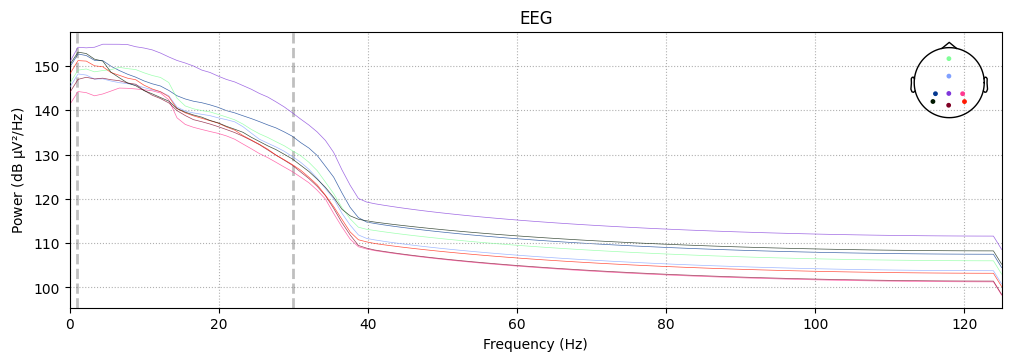

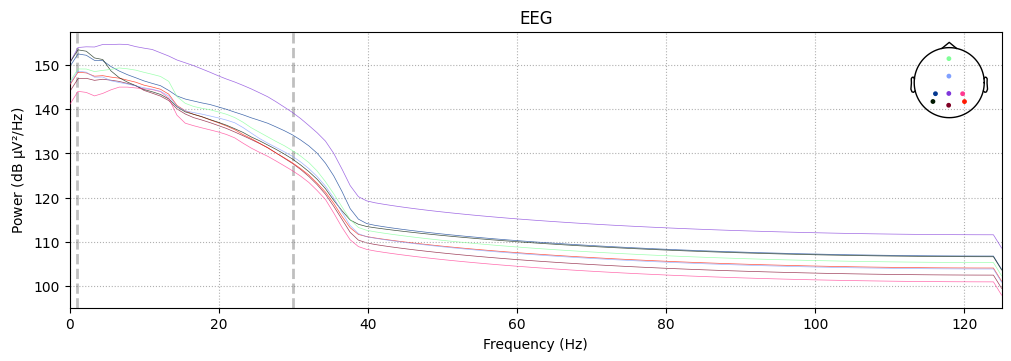

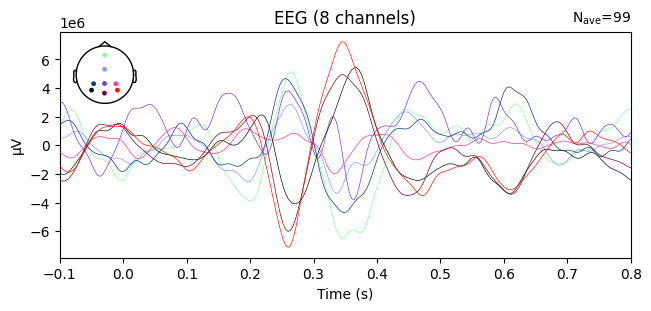

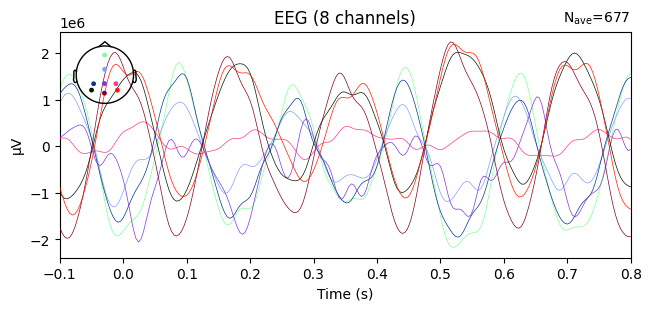

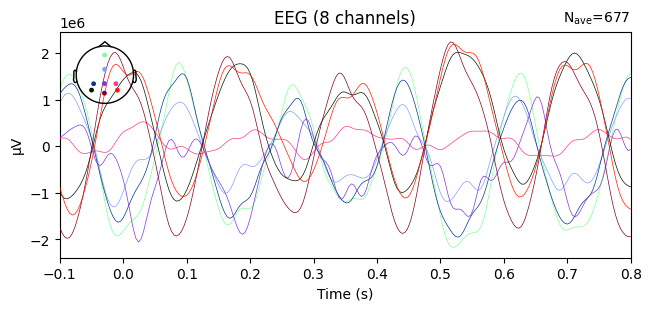

In [ ]:
# Plot the Power Spectral Density
psd_targets = cleaned_epochs['target'].plot_psd(show=True)
psd_nontargets = cleaned_epochs['non-target'].plot_psd(show=True)

# plot evoked signals
evoked_trg = cleaned_epochs['target'].average()
evoked_nontrg = cleaned_epochs['non-target'].average()
evoked_trg.plot()
evoked_nontrg.plot()

# ML Code

# Subject 4

In [ ]:
cleaned_epochs['target']

Number of events,99
Events,target: 99
Time range,-0.100 – 0.800 s
Baseline,-0.100 – 0.000 s


In [ ]:
cleaned_epochs['non-target']

Number of events,677
Events,non-target: 677
Time range,-0.100 – 0.800 s
Baseline,-0.100 – 0.000 s


In [ ]:
epochs


Number of events,776
Events,non-target: 677target: 99
Time range,-0.100 – 0.800 s
Baseline,-0.100 – 0.000 s


In [ ]:
event_id

{'non-target': -1, 'target': 1}

In [ ]:
# # Extract indices for targets and non-targets from previously cleaned trigger data

cleaned_raw, cleaned_trig= reject_artifacts(raw,trig,threshold=3.0)
targets = np.where(cleaned_trig == 1)[0]
non_targets = np.where(cleaned_trig == -1)[0]

Creating RawArray with float64 data, n_channels=8, n_times=60282
    Range : 0 ... 60281 =      0.000 ...   241.124 secs
Ready.


In [ ]:
targets.shape,non_targets.shape

((149,), (1046,))

In [ ]:
data = cleaned_epochs

In [ ]:
data = data.to_data_frame()


In [ ]:
data.head(5)

,time,condition,epoch,Fz,Cz,P3,Pz,P4,PO7,Oz,PO8
0,-0.100,non-target,0,-1.031715e+06,5.984901e+05,1.188504e+06,-1.186947e+07,6.616459e+05,6.460077e+06,1.375457e+06,2.617010e+06
1,-0.096,non-target,0,-1.590934e+06,2.358288e+06,-7.585576e+05,-1.070470e+07,1.424549e+06,5.830607e+06,1.484105e+06,1.956646e+06
2,-0.092,non-target,0,-1.209238e+06,4.039541e+06,-1.307713e+06,-9.813206e+06,1.943374e+06,4.820579e+06,8.400323e+05,6.866308e+05
3,-0.088,non-target,0,3.833146e+05,5.403373e+06,-4.205275e+05,-9.229959e+06,1.915561e+06,3.399682e+06,-4.855834e+05,-9.658609e+05
4,-0.084,non-target,0,2.921171e+06,6.342895e+06,1.359755e+06,-8.770439e+06,1.213058e+06,1.715022e+06,-2.186628e+06,-2.594832e+06


In [ ]:
#data.iloc[:,1].value_counts()

condition
non-target    153002
target         22374
Name: count, dtype: int64

In [ ]:
x_data = data[["Fz","Cz",	"P3",	"Pz",	"P4",	"PO7",	"Oz",	"PO8"]]

In [ ]:
x_data.head()

,Fz,Cz,P3,Pz,P4,PO7,Oz,PO8
0,-1.031715e+06,5.984901e+05,1.188504e+06,-1.186947e+07,6.616459e+05,6.460077e+06,1.375457e+06,2.617010e+06
1,-1.590934e+06,2.358288e+06,-7.585576e+05,-1.070470e+07,1.424549e+06,5.830607e+06,1.484105e+06,1.956646e+06
2,-1.209238e+06,4.039541e+06,-1.307713e+06,-9.813206e+06,1.943374e+06,4.820579e+06,8.400323e+05,6.866308e+05
3,3.833146e+05,5.403373e+06,-4.205275e+05,-9.229959e+06,1.915561e+06,3.399682e+06,-4.855834e+05,-9.658609e+05
4,2.921171e+06,6.342895e+06,1.359755e+06,-8.770439e+06,1.213058e+06,1.715022e+06,-2.186628e+06,-2.594832e+06


In [ ]:
x_data.shape # whole data

(175376, 8)

In [ ]:
labels =  data["condition"]

In [ ]:
labels.shape

(175376,)

In [ ]:
labels

0         non-target
1         non-target
2         non-target
3         non-target
4         non-target
             ...    
175371    non-target
175372    non-target
175373    non-target
175374    non-target
175375    non-target
Name: condition, Length: 175376, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, labels, test_size = 0.2, random_state = 42)

In [ ]:
x_train.shape,y_test.shape,x_test.shape,y_train.shape

((140300, 8), (35076,), (35076, 8), (140300,))

In [152]:
#features extraction
#import mne_features as mf
#fc=[]

#x_features = mf.univariate.compute_ptp_amp(x_train1)
    #fc.append(x_features)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kclf = KNeighborsClassifier()
kclf.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = kclf.predict(X_test)
#cm = confusion_matrix(y_test, y_pred)
#print(cm)
accuracy_score(y_test, y_pred)

0.9051488197057818

In [ ]:
y_test

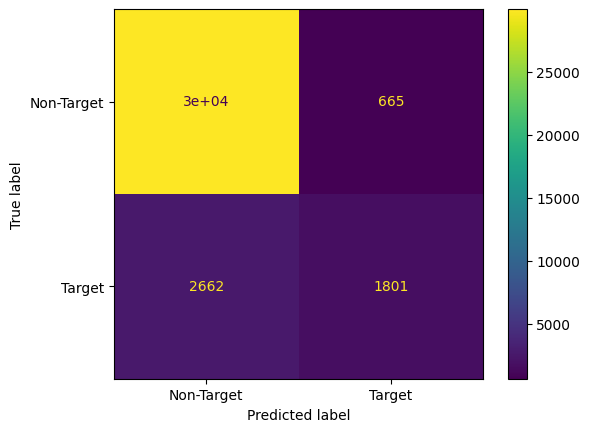

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from numpy import argmax
#Y_testNN1=argmax(Y_testNN, axis=1, out=None)
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Non-Target','Target'])
disp.plot()

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# F1 Score
F1=2*((PPV*TPR)/(PPV+TPR))
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

In [ ]:
from sklearn import metrics
#Accuracy
print("Accuracy : ")
print(round(metrics.accuracy_score(y_test,y_pred)*100,2))

#TPR - sensitivity
print("\nSensitivity : ")
print(round((sum(TPR)/len(TPR))*100,2))

#TNR - specificity
print("\nSpecificity : ")
print(round((sum(TNR)/len(TNR))*100,2))

#Precision
print("\nPrecision : ")
print(round((sum(PPV)/len(PPV))*100,2))

#F1
print("\nF1 : ")
print(round((sum(F1)/len(F1))*100,2))

Accuracy : 
90.51

Sensitivity : 
69.09

Specificity : 
69.09

Precision : 
82.44

F1 : 
73.36


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=12)
        plt.yticks(tick_marks, target_names,fontsize=12)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            #plt.text(j, i, "{:0.4f}".format(cm[i, j]),
            plt.text(j, i, "{:0.2f}%".format(cm[i, j]*100),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize='large' )
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]*100),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize = 'large')


    plt.tight_layout()
    plt.ylabel('True label',fontsize=12)
    plt.xlabel('Predicted label',fontsize=12)#\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.grid(False)
    #plt.savefig('Cm RF.jpg',dpi = 1000, bbox_inches="tight")
    plt.show()

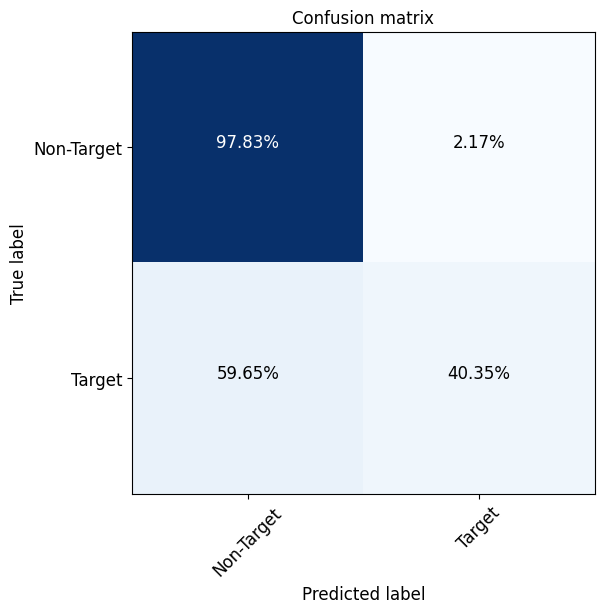

In [ ]:
plot_confusion_matrix(cm,
                          target_names=['Non-Target','Target'],
                          title='Confusion matrix')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
